In [ ]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpyro
numpyro.set_host_device_count(2)

/opt/homebrew/Caskroom/miniforge/base/envs/diffwaveform/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/opt/homebrew/Caskroom/miniforge/base/envs/diffwaveform/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import scipy.signal as ssig
import lalsimulation as lalsim 
import numpy as np
import jax.numpy as jnp
import jax
import arviz as az
import corner

import matplotlib.pyplot as plt
from diffwaveform.waveforms.IMRPhenomD import gen_IMRPhenomD

### First lets look at generating some noise with lalsim (from Max's notebook)

In [4]:
psd_func_dict = {
    'H1': lalsim.SimNoisePSDaLIGOZeroDetHighPower,
    'L1': lalsim.SimNoisePSDaLIGOZeroDetHighPower,
    'V1': lalsim.SimNoisePSDAdvVirgo,
}
ifos = list(psd_func_dict.keys())

In [5]:
print(psd_func_dict["H1"](50.0))

2.4758979023280866e-47


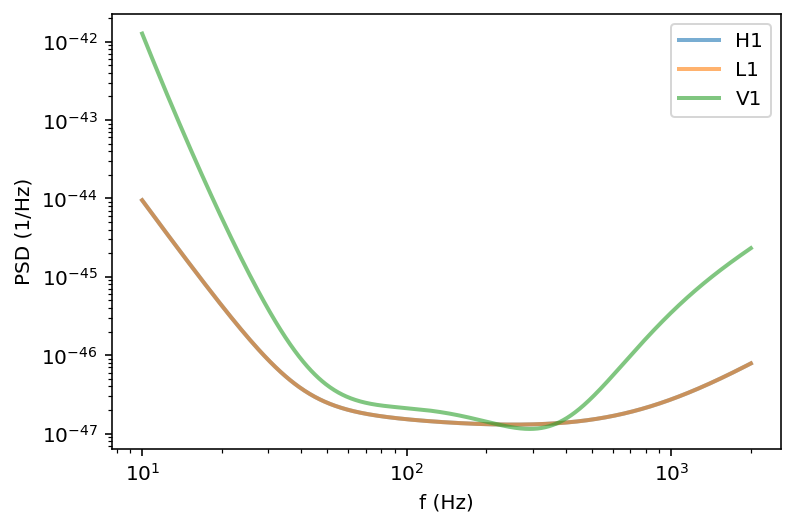

In [6]:
fs = np.linspace(10, 2e3, 4096)
for ifo, psd in psd_func_dict.items():
    plt.loglog(fs, np.vectorize(psd)(fs), label=ifo, alpha=0.6, lw=2)
plt.xlabel('f (Hz)')
plt.ylabel('PSD (1/Hz)')
plt.legend()
plt.show()

In [7]:
# define center of time array
tgps_geo = 1126259462.423

# define sampling rate and duration
fsamp = 8192
duration = 4

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))

epoch = tgps_geo - 0.5*tlen*delta_t

time_dict = {i: np.arange(tlen)*delta_t + epoch for i in ifos}

In [8]:
f_l = 30
f_u = 1024
df = 0.001
f_list = np.arange(f_l, f_u, df)

freqs = np.fft.rfftfreq(tlen, delta_t)
delta_f = freqs[1] - freqs[0]

In [9]:
# we will want to pad low frequencies; the function below applies a
# prescription to do so smoothly, but this is not really needed: you
# could just set all values below `fmin` to a constant.
fmin = 10
def pad_low_freqs(f, psd_ref):
    return psd_ref + psd_ref*(fmin-f)*np.exp(-(fmin-f))/3

psd_dict = {}
for ifo in ifos:
    psd = np.zeros(len(freqs))
    for i,f in enumerate(freqs):
        if f >= fmin:
            psd[i] = psd_func_dict[ifo](f)
        else:
            psd[i] = pad_low_freqs(f, psd_func_dict[ifo](fmin))
    psd_dict[ifo] = psd

In [10]:
rng = np.random.default_rng(12345)

noise_fd_dict = {}
for ifo, psd in psd_dict.items():
    var = psd / (4.*delta_f)  # this is the variance of LIGO noise given the definition of the likelihood function
    noise_real = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_imag = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_fd_dict[ifo] = noise_real + 1j*noise_imag

/opt/homebrew/Caskroom/miniforge/base/envs/diffwaveform/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


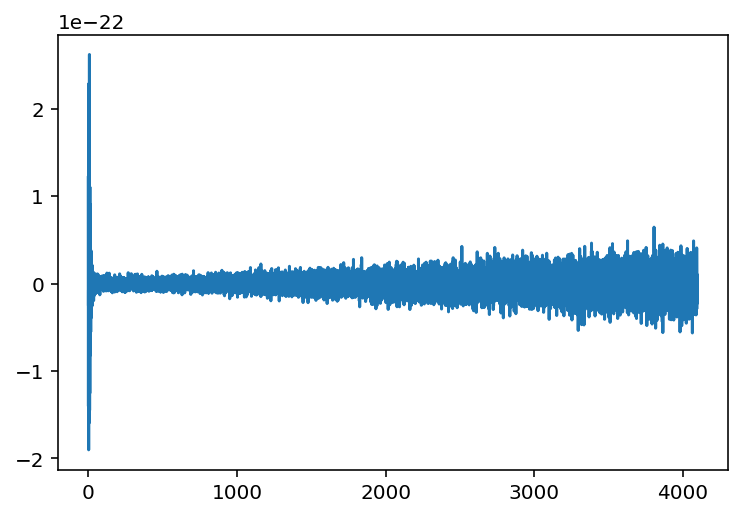

In [11]:
# So now lets look at the noise we have generated in H1. Looks good to me!
plt.plot(freqs, noise_fd_dict["H1"])

### Now lets generate a waveform and add them together

In [12]:
# Now lets compute the waveform ripple
m1 = 20.0
m2 = 10.0
from diffwaveform import ms_to_Mc_eta
Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
chi1 = 0.0
chi2 = 0.0
D = 100.0
tc = 0.01
phic = 0.0

f_list = freqs[freqs>fmin]
sigma_list = np.sqrt(var[freqs>fmin])
params = jnp.array([Mc, eta, chi1, chi2, D, tc, phic])
hp = gen_IMRPhenomD(f_list, params)

/opt/homebrew/Caskroom/miniforge/base/envs/diffwaveform/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/homebrew/Caskroom/miniforge/base/envs/diffwaveform/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


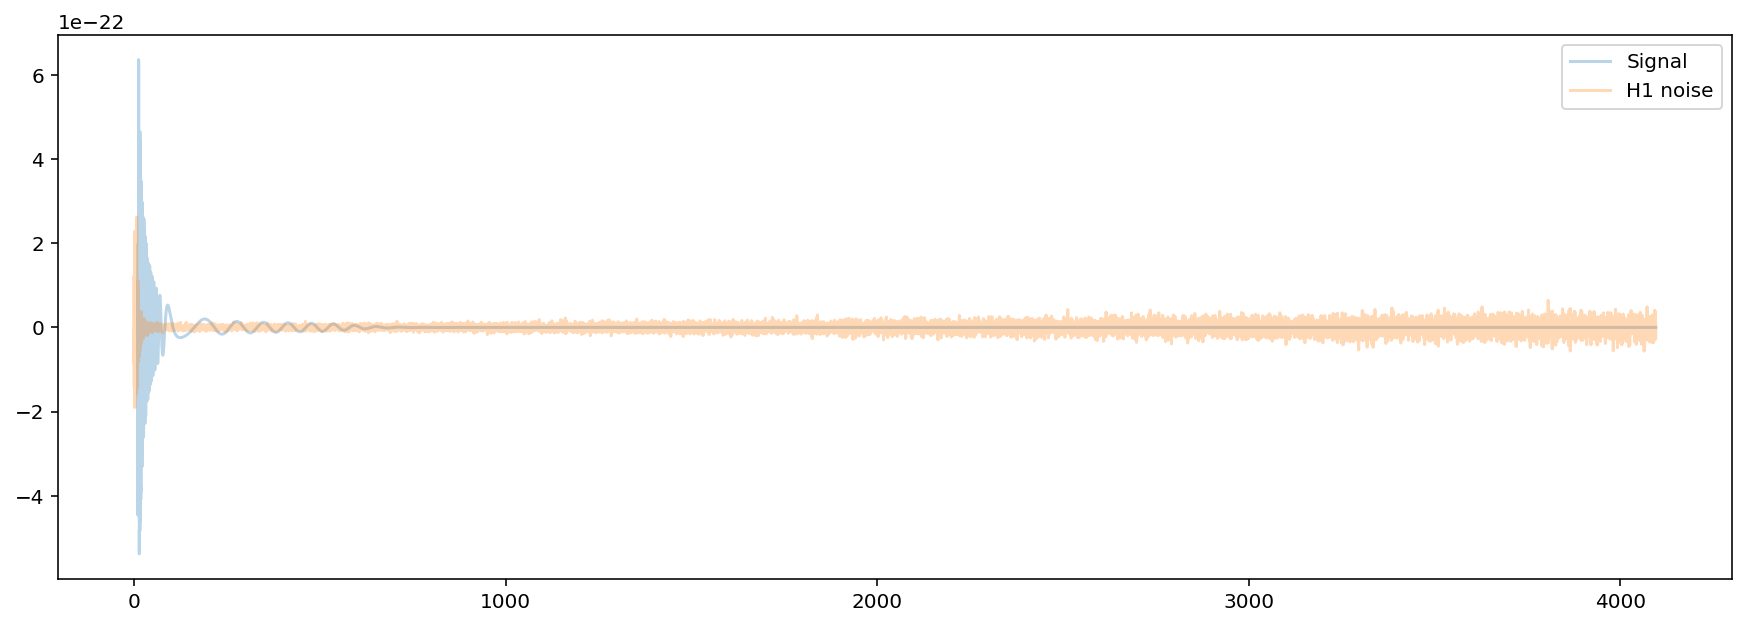

In [13]:
plt.figure(figsize=(15,5))
plt.plot(f_list, hp, label="Signal", alpha=0.3)
plt.plot(freqs, noise_fd_dict["H1"], label="H1 noise", alpha=0.3)
plt.legend()
plt.show()

In [14]:
# Note that I'm only using frequencies above 10 Hz since the waveform generation is not 
# reliable below this
data = noise_fd_dict["H1"][freqs>fmin] + hp

### Finally, lets set up a numpyro MCMC

In [15]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value

prior_sigma_Mc = 5.0
prior_sigma_eta = 0.1
prior_sigma_chi = 5.0
prior_sigma_D = 10.0

prior_sigma_tc = 0.01
prior_sigma_phic = 0.01


def numpyro_likelihood(f, sigma, y=None):
    # Parameters of the model
    log_Mc = numpyro.sample("log_Mc", dist.Normal(np.log(Mc), prior_sigma_Mc))
    log_eta = numpyro.sample("log_eta", dist.Normal(np.log(eta), prior_sigma_eta))
    
    chi1_ = numpyro.sample("chi1", dist.Normal(chi1, prior_sigma_chi))
    chi2_ = numpyro.sample("chi2", dist.Normal(chi2, prior_sigma_chi))
    
    log_D = numpyro.sample("log_D", dist.Normal(np.log(D), prior_sigma_D))
    
    tc_ = numpyro.sample("tc", dist.Uniform(tc-prior_sigma_tc, tc+prior_sigma_tc))
    phic_ = numpyro.sample("phic", dist.Normal(phic, prior_sigma_phic))
    
    # This is the part I'm not sure I understand...
    # I'm not sure which part should be data and which part is 
    params = jnp.array([jnp.exp(log_Mc), jnp.exp(log_eta), chi1_, chi2_, jnp.exp(log_D), tc_, phic_])
    waveform = gen_IMRPhenomD(f, params)
    
    # Likelihood definition
    numpyro.sample(
        "real_obs", dist.Normal(waveform.real, sigma), obs=None if y is None else y.real
    )
    numpyro.sample(
        "imag_obs", dist.Normal(waveform.imag, sigma), obs=None if y is None else y.imag
    )

In [16]:
init = {
    "log_Mc": np.log(Mc),
    "log_eta": np.log(eta),
    "chi1": chi1,
    "chi2": chi2,
    "log_D": np.log(D),
    "tc": tc,
    "phic": phic,
}
nuts_kernel = NUTS(
    numpyro_likelihood, dense_mass=True, target_accept_prob=0.9,
    init_strategy=init_to_value(values=init)
)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=2,
    progress_bar=True,
)
rng_key = jax.random.PRNGKey(34923)

mcmc.run(rng_key, f_list[::100], sigma_list[::100], y=data[::100])
samples = mcmc.get_samples()

Compiling.. :   0%|                                                                                                                                                                                                  | 0/2000 [00:00<?, ?it/s]2022-04-18 21:34:20.501475: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:61] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module pmap__unnamed_wrapped_function_.29
********************************
Running chain 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:14<00:00,  5.34it/s]


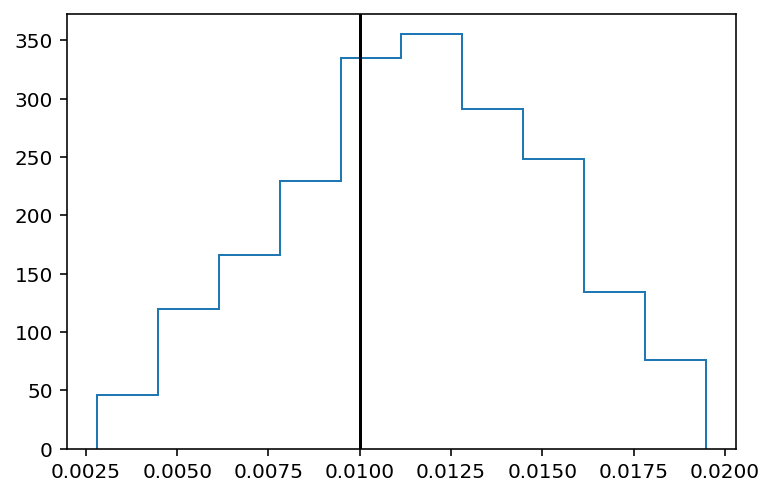

In [17]:
plt.hist(np.array(samples["tc"]), histtype="step")
plt.axvline(tc, color="k");

In [18]:
trace = az.from_numpyro(mcmc)
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
chi1,0.090,0.449,-0.800,0.838,0.077,0.055,37.0,82.0,1.07
chi2,-0.250,0.896,-1.737,1.494,0.152,0.109,33.0,67.0,1.08
log_D,4.613,0.034,4.552,4.674,0.002,0.001,483.0,816.0,1.01
log_Mc,2.503,0.004,2.494,2.511,0.000,0.000,206.0,152.0,1.01
log_eta,-1.479,0.039,-1.553,-1.413,0.003,0.002,179.0,281.0,1.02
phic,-0.000,0.010,-0.019,0.018,0.000,0.000,804.0,772.0,1.01
tc,0.012,0.004,0.005,0.018,0.001,0.000,45.0,79.0,1.07


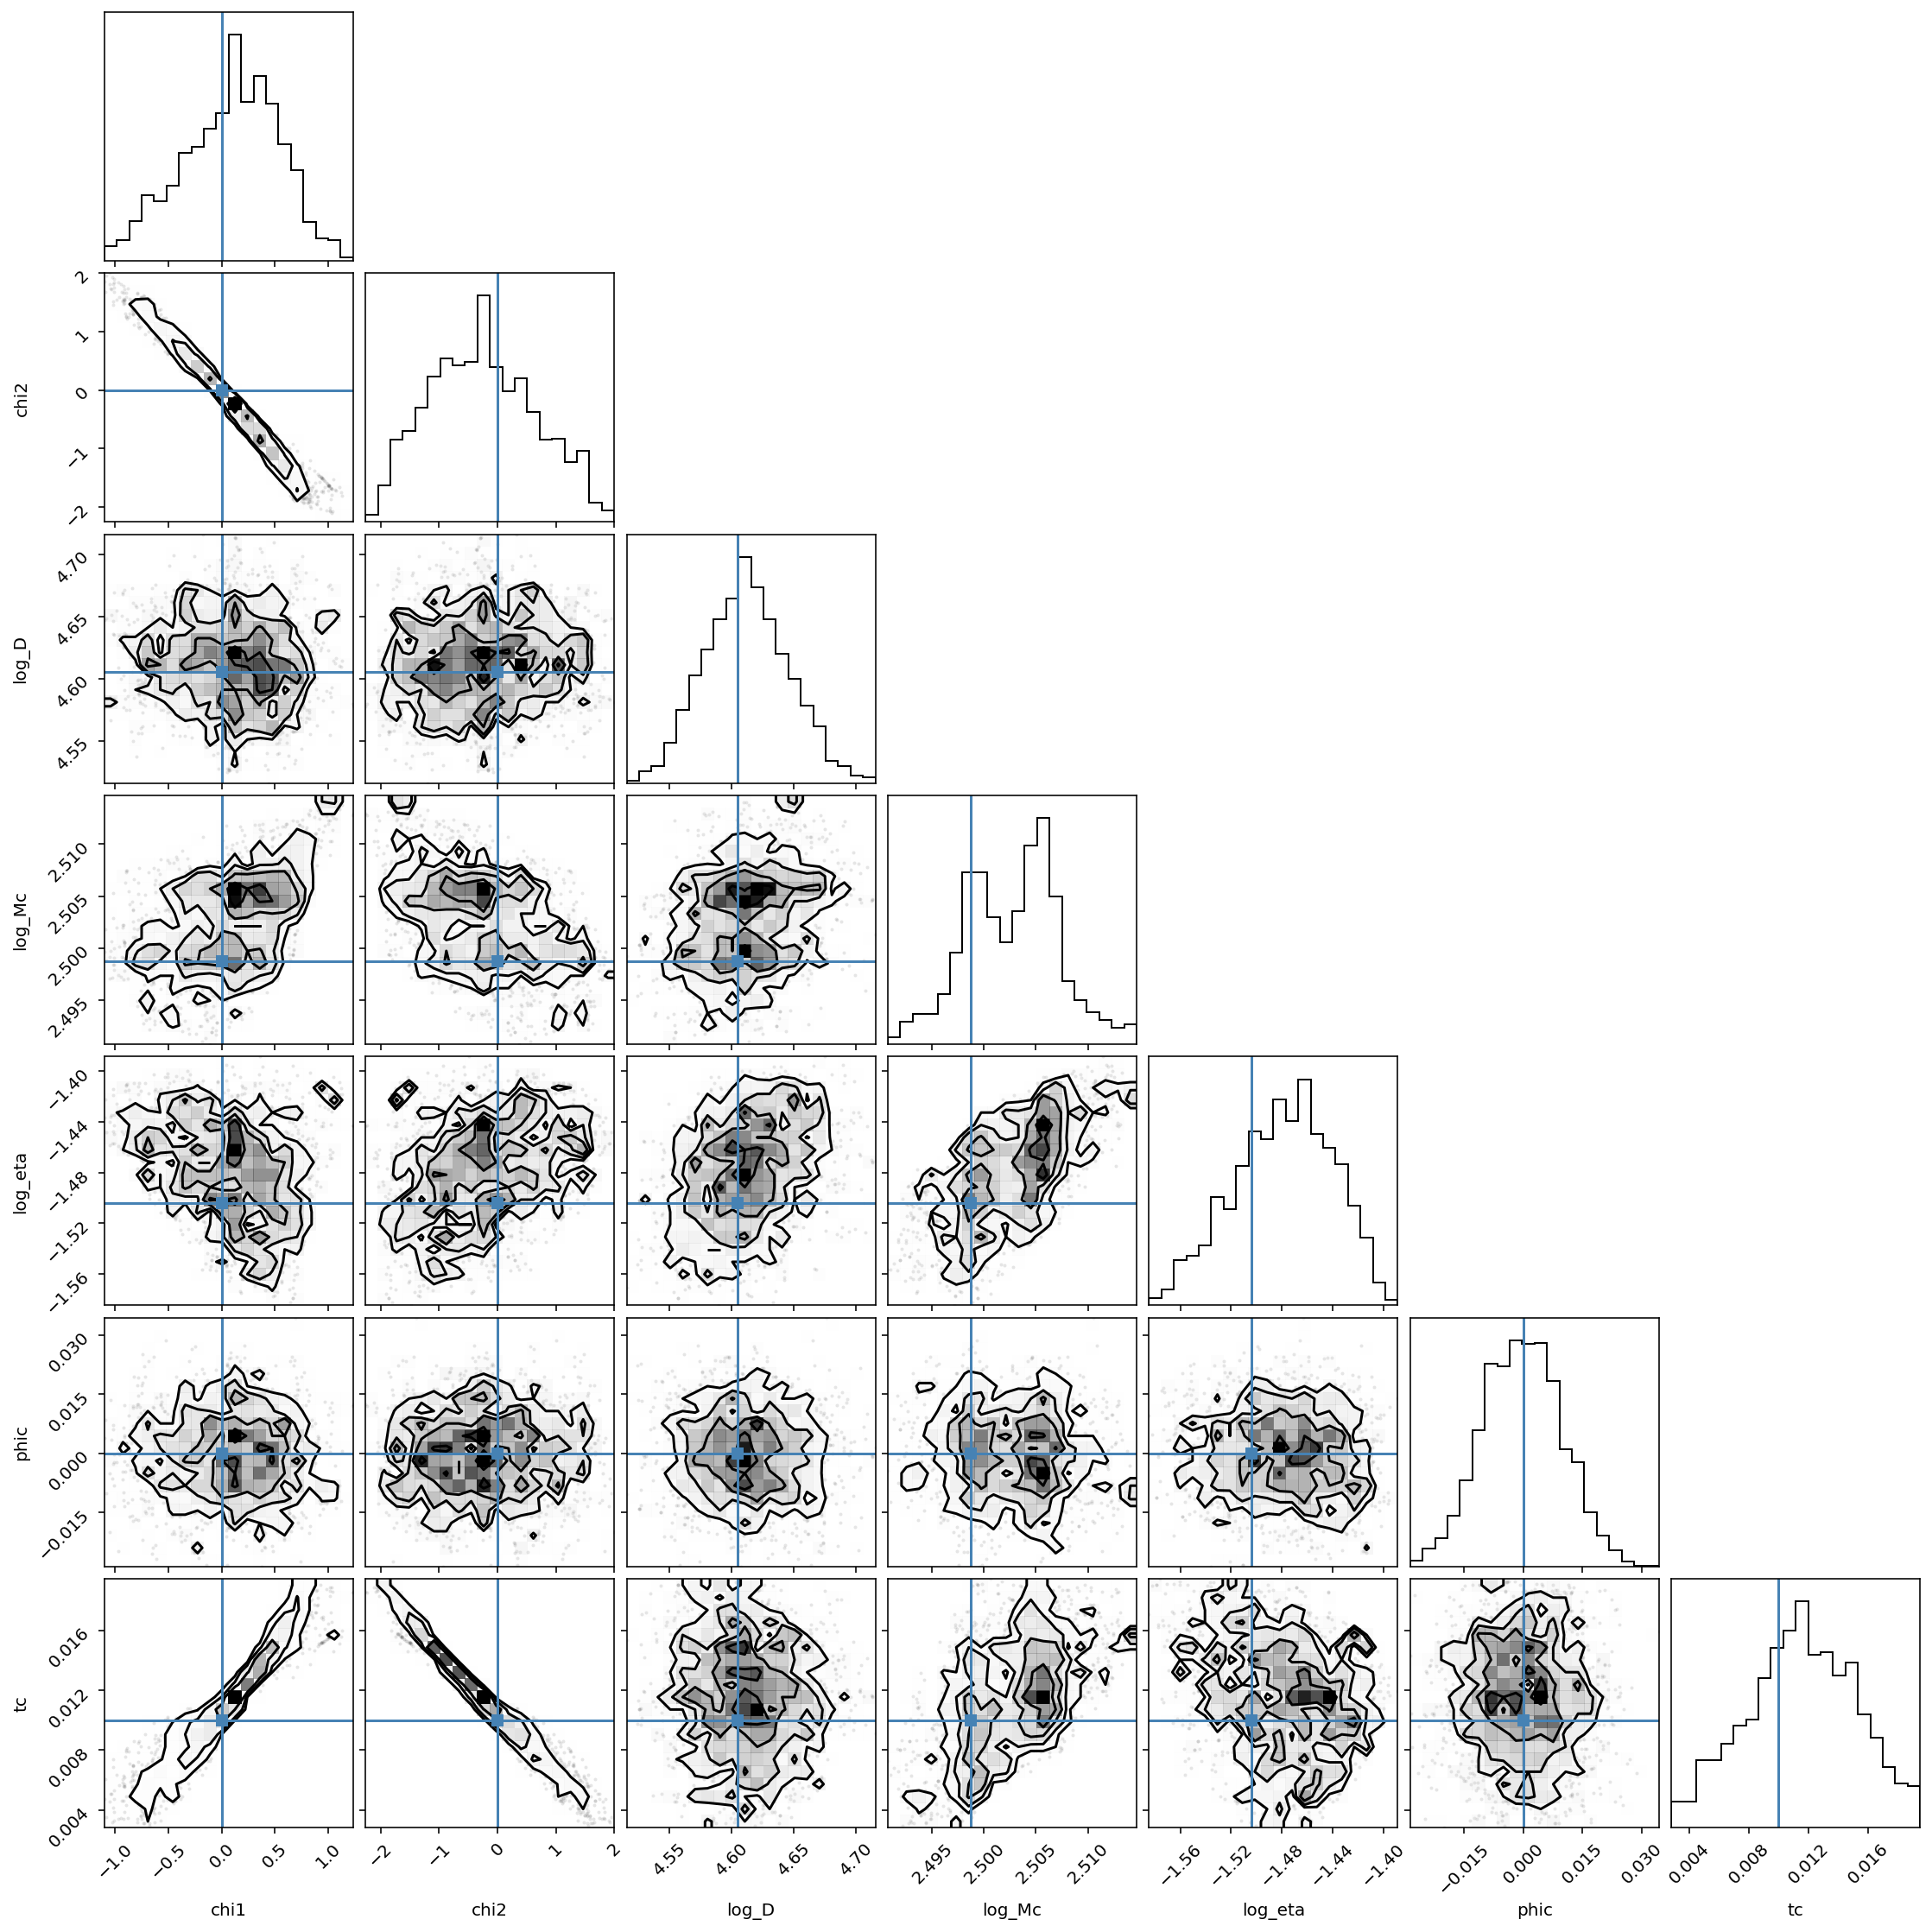

In [19]:
corner.corner(trace, truths=init);